# Adult Income Prediction notebook
This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). *The prediction task is to determine whether a person makes over  USD 50K a year.*  
This is a binary classification problem where we have to predict whether a person earns over $50k per year or not. The scoring function to optimize is accuracy. The notebook follows the following steps to analyse the data and build predictive models.
- Data cleaning and preprocessing
- Exploratory data analysis
- Modelling: I have tried out different classification algorithms.
  - Random forest
  - XGBoost
  - Naive Bayes
  - Logistic regression
  - CatBoost  
These models were then optimized by tuning the hyper-parameters through Grid Search, keeping a close check on the cross-validation scores to prevent overfitting. Thereafter I also tried out stacking different models together to improve the accuracy but it didn't improve the accuracy sigificantly.
- Finally I explored oversampling techniques including SMOTE.

Please feel free to suggest/comment.

<img src="money.jpg" style="width: 600px;"/>


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
import os
import seaborn as sns
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [78]:
sns.set() ##set defaults

In [79]:
%matplotlib inline

In [80]:
data = pd.read_csv("adult.csv")

In [81]:
data.shape

(32561, 15)

In [82]:
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [84]:
data['workclass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [85]:
data['income'].value_counts()    # Is the target variable skewed?

<=50K    24720
>50K      7841
Name: income, dtype: int64

#### Encode the target variable to binary

In [86]:
data['income'] = data['income'].apply(lambda inc: 0 if inc == "<=50K" else 1) # Binary encoding of the target variable

## Exploratory analysis

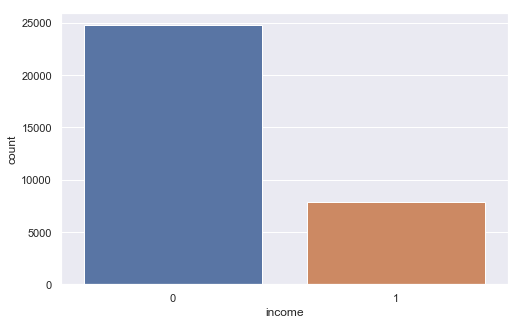

In [87]:
plt.figure(figsize=(8,5))
sns.countplot(data['income'])

#### As one can see, there is considerable class imbalance in the target variable, i.e. income. This is also intuitively obvious as one expects fewer 'rich' people (earning>50k/annum) than 'not-so-rich' people (earning <50k/annum). Therefore we might need to consider over-sampling techniques in our ML model to improve our accuracy.

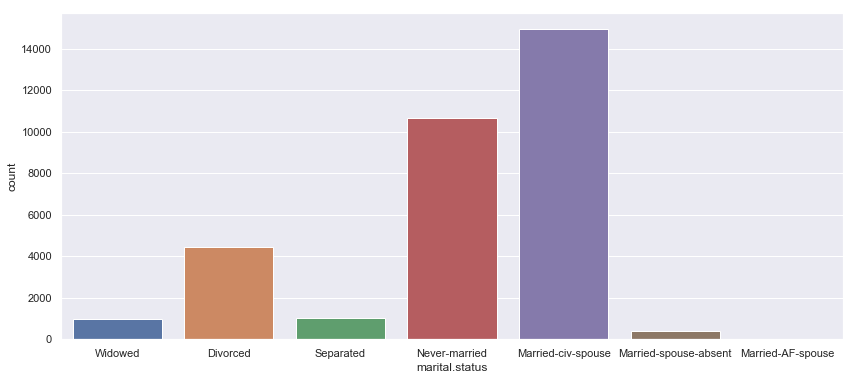

In [88]:
plt.figure(figsize=(14,6))
sns.countplot(data['marital.status'])

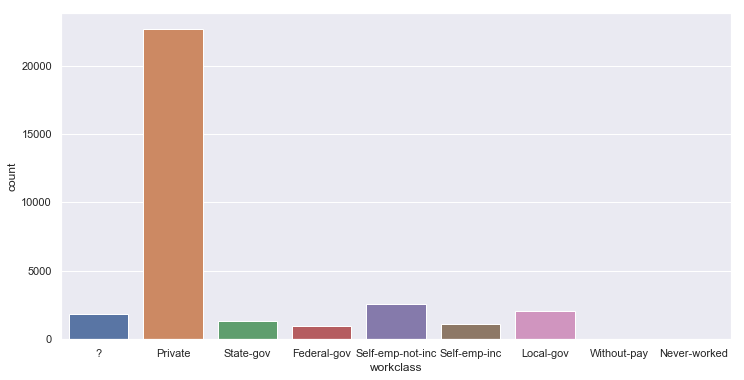

In [89]:
plt.figure(figsize=(12,6))
sns.countplot(data['workclass'])

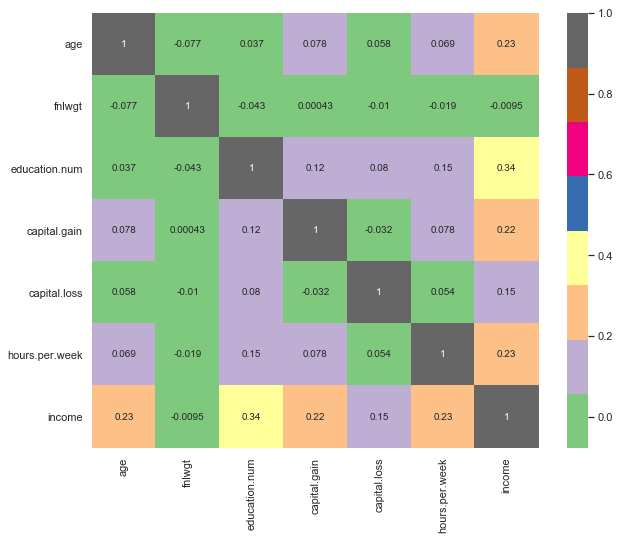

In [90]:
plt.figure(figsize=(10,8))  
sns.heatmap(data.corr(),cmap='Accent',annot=True)
#data.corr()

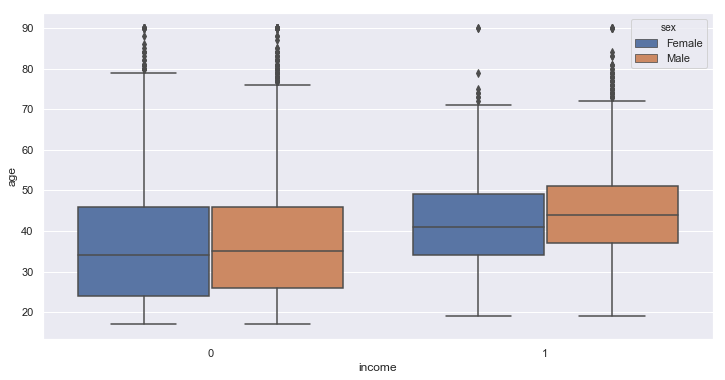

In [91]:
plt.figure(figsize=(12,6))
sns.boxplot(x="income", y="age", data=data, hue='sex')
#data[data['income']==0]['age'].mean()

The mean age of people earning more than 50k per annum is around 44 whereas the mean age of of those earning less than 50k per annum is 36.

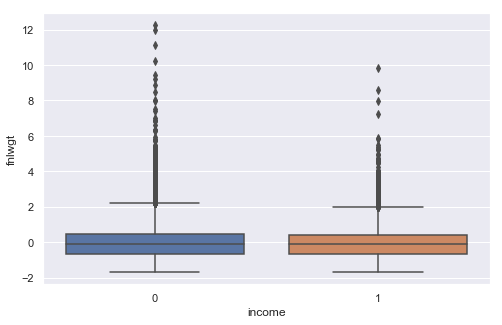

In [92]:
norm_fnl = (data["fnlwgt"] - data['fnlwgt'].mean())/data['fnlwgt'].std()
plt.figure(figsize=(8,5))
sns.boxplot(x="income", y=norm_fnl, data=data)

As evident from the plot above, there are many outliers in the `fnlwgt` column and this feature is uncorrelated with `income`, our target variable. The correlation coefficient (which one can read from the heatmap) is -0.0095. The number of outliers, i.e. the number of records which are more than 2 s.d's away from the mean, is 1249.

In [93]:
data[norm_fnl>2].shape

(1249, 15)

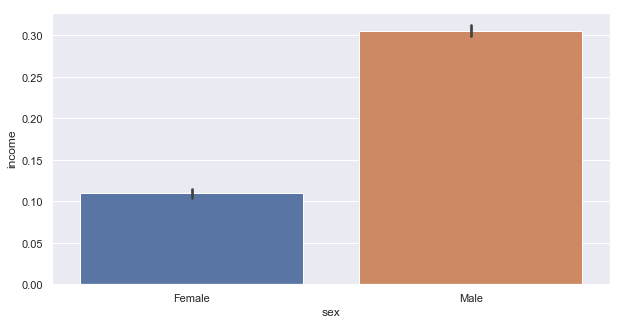

In [94]:
plt.figure(figsize=(10,5))
sns.barplot(x='sex',y='income',data=data)

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64

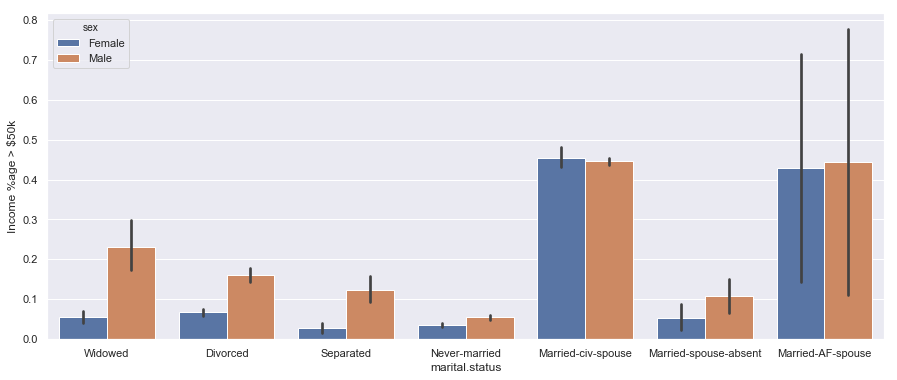

In [142]:
plt.figure(figsize=(15,6))
ax=sns.barplot(x='marital.status',y='income',data=data,hue='sex')
ax.set(ylabel='Income %age > $50k')
data['marital.status'].value_counts()

The above plot shows the the fraction of people earning more than $50k per annum, grouped by their marital status and gender. The data shows that married people have a higher %age of high-earners, compared to those who either never married or are widowed/divorced/separated. The black lines indicate the standard deviation in the data set. The married spouses of armed forces personnel have a much higher variation in their income compared to civil spouses because of low-number statistics.

In [96]:
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

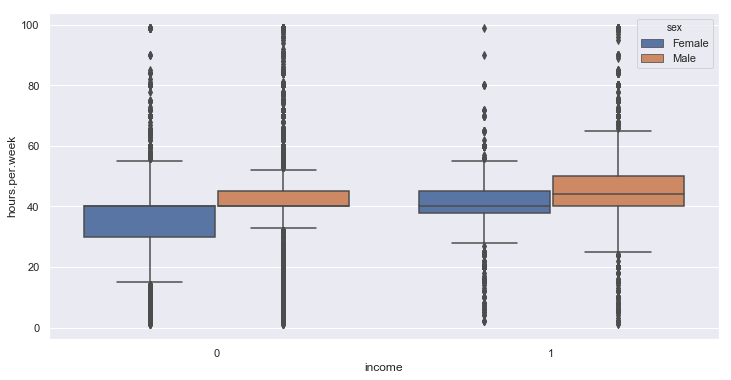

In [140]:
plt.figure(figsize=(12,6))
sns.boxplot(x='income',y ='hours.per.week', hue='sex',data=data)

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64

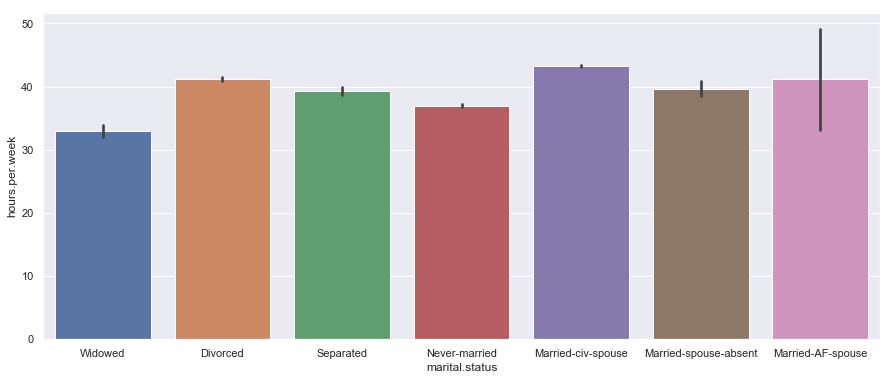

In [141]:
plt.figure(figsize=(15,6))
sns.barplot(x='marital.status',y='hours.per.week',data=data)#,hue='sex')

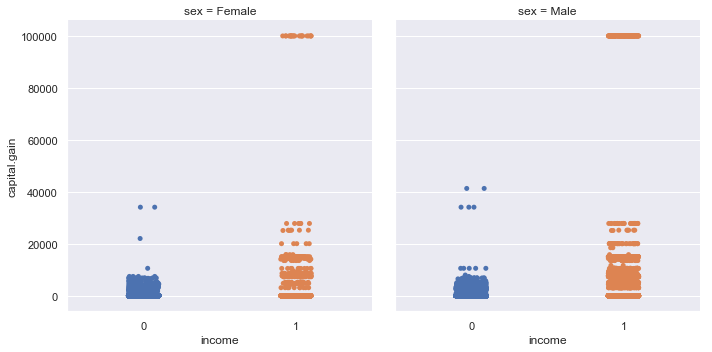

In [98]:
sns.catplot(x='income', y='capital.gain',col='sex',data=data)

1    27504
0     3214
Name: native.country, dtype: int64
30718 people are not from the United States


/Users/debashis/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


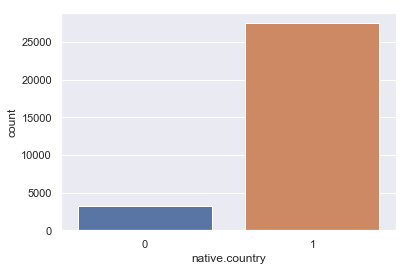

In [70]:
print(data['native.country'].value_counts())
sns.countplot(data['native.country'])
not_from_US = np.sum(data['native.country']!='United-States')
print(not_from_US, 'people are not from the United States')

In [42]:
data['native.country'] = (data['native.country']=='United-States')*1

In [43]:
data.select_dtypes(exclude=[np.number]).head()

,workclass,education,marital.status,occupation,relationship,race,sex
0,?,HS-grad,Widowed,?,Not-in-family,White,Female
1,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female
2,?,Some-college,Widowed,?,Unmarried,Black,Female
3,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female
4,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female


In [44]:
data = data.applymap(lambda x: np.nan if x=='?' else x) #Replace all '?'s with NaNs.

In [45]:
data.isnull().sum(axis=0)

age                         0
workclass                1836
fnlwgt                      0
education                   0
education.num               0
marital.status              0
occupation               1843
relationship                0
race                        0
sex                         0
capital.gain                0
capital.loss                0
hours.per.week              0
native.country              0
income                      0
binary_native_country       0
dtype: int64

In [46]:
data.shape[0] - data.dropna(axis=0).shape[0]   # how many rows will be removed if I remove all the NaN's?

1843

In [47]:
data = data.dropna(axis=0) ## Drop all the NaNs

In [48]:
data.education.value_counts()  # I will label-encode the education column since it is an ordinal categorical variable

HS-grad         9968
Some-college    6775
Bachelors       5182
Masters         1675
Assoc-voc       1321
11th            1056
Assoc-acdm      1020
10th             831
7th-8th          573
Prof-school      558
9th              463
Doctorate        398
12th             393
5th-6th          303
1st-4th          156
Preschool         46
Name: education, dtype: int64

In [49]:
## This computes the fraction of people by country who earn >50k per annum
mean_income_bycountry_df = data[['native.country','income']].groupby(['native.country']).mean().reset_index()

In [50]:
edu_encode_dict = {'Preschool':0,'1st-4th':1, '5th-6th':2, '7th-8th':3, '9th':4, '10th':5,
                  '11th':6, '12th':7, 'HS-grad':8, 'Some-college':9, 'Bachelors':10, 'Masters':11, 'Assoc-voc':12, 
                   'Assoc-acdm':13, 'Doctorate':14, 'Prof-school':15}

data['education'] = data['education'].apply(lambda ed_level: edu_encode_dict[ed_level])

### One-hot encoding of the categorical columns

In [51]:
data = pd.get_dummies(data,columns=['workclass','sex', 'marital.status',
                                    'race','relationship','occupation'],
               prefix=['workclass', 'is', 'is', 'race_is', 'relation', 'is'], drop_first=True)
### native country is ignored because that feature will be dropped later

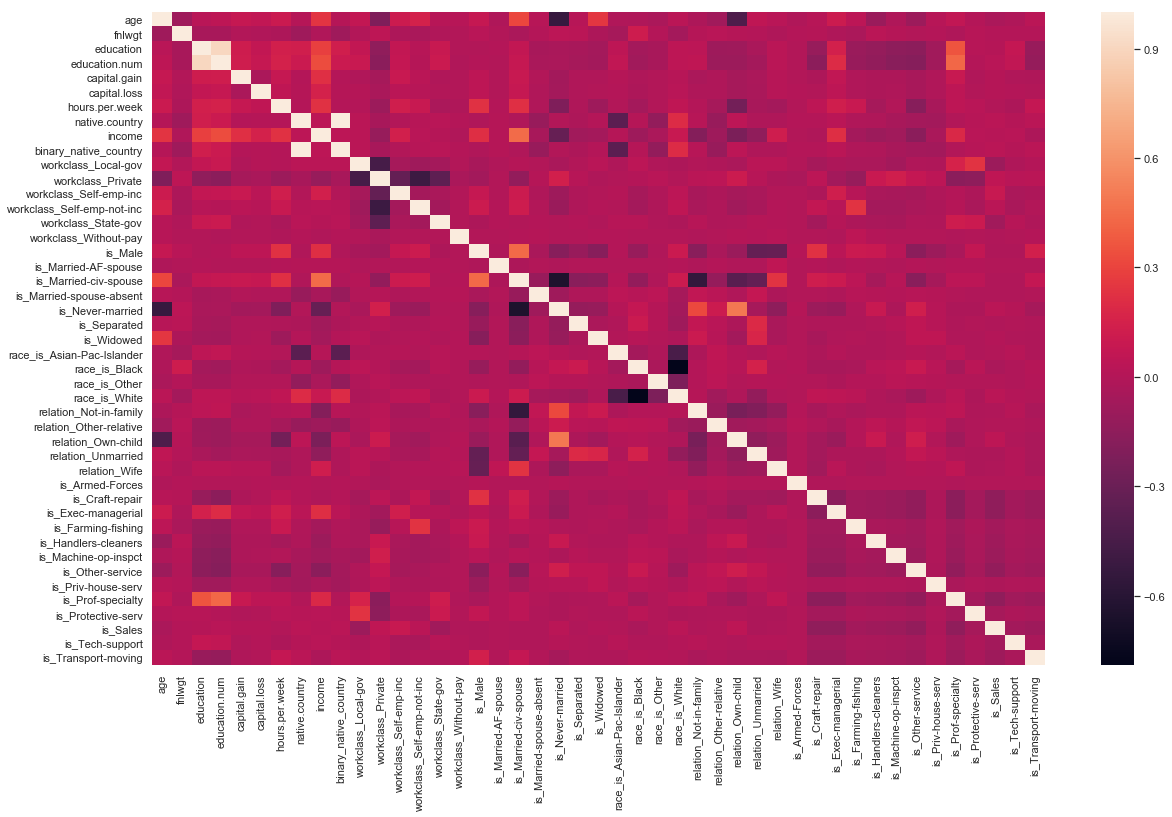

In [52]:
plt.figure(figsize=(20,12))
sns.heatmap(data.corr())

In [53]:
data.select_dtypes(exclude=[np.number]).shape

(30718, 0)

In [54]:
#data['foo']=np.where(data['native.country']=='United-States',1,0)

In [55]:
data.groupby('income').mean()

,age,fnlwgt,education,education.num,capital.gain,capital.loss,hours.per.week,native.country,binary_native_country,workclass_Local-gov,...,is_Farming-fishing,is_Handlers-cleaners,is_Machine-op-inspct,is_Other-service,is_Priv-house-serv,is_Prof-specialty,is_Protective-serv,is_Sales,is_Tech-support,is_Transport-moving
income,,,,,,,,,,,,,,,,,,,,,
0,36.612190,190419.176782,8.464323,9.636509,148.055618,53.528524,39.371900,0.889067,0.889067,0.063985,...,0.038105,0.055662,0.075949,0.136900,0.006416,0.098882,0.018987,0.115615,0.027961,0.055358
1,43.966013,188115.803660,9.978824,11.619346,3994.758170,195.601046,45.705882,0.914379,0.914379,0.080654,...,0.015033,0.011242,0.032680,0.017908,0.000131,0.243007,0.027582,0.128497,0.036993,0.041830


In [56]:
data.shape

(30718, 45)

In [57]:
y = data.income
X = data.drop(['income', 'education', 'native.country', 'fnlwgt'],axis=1)

- `income` is dropped from X because it is the target variable.
- `Education` is dropped because it is already label-encoded in `education.num`. One can notice the high correlation between `education` and `education.num` in the heatmap.
- `native country` is dropped because it showed very little feature importance in random forest classifer.
- `fnlwgt` is dropped because it has no correlation with `income`.

## Modelling
This section explores different classification algorithms to maximise the accuracy for predicting income of a person (> 50k/yr or < 50k/yr).

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
# Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier as xgb
from sklearn import metrics

### Baseline model
In the baseline model, we predict the minority class for all our train and test (or validation) examples. The resulting accuracy will serve as a benchmark for the ML models. In other words, the sophisticated ML models should have an accuracy which should at least better the baseline one.

In [61]:
baseline_train = np.zeros(y_train.shape[0])
baseline_test = np.zeros(y_test.shape[0])
print('Accuracy on train data: %f%%' % (metrics.accuracy_score(y_train, baseline_train)))
print('Accuracy on test data: %f%%' %  (metrics.accuracy_score(y_test, baseline_test)))

Accuracy on train data: 0.750442%
Accuracy on test data: 0.752170%


### Random Forest classifier

In [62]:
rfmodel = RandomForestClassifier(n_estimators=300,oob_score=True,min_samples_split=5, max_depth=10,random_state=10)
rfmodel.fit(X_train,y_train)
print(rfmodel)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=True, random_state=10, verbose=0, warm_start=False)


In [63]:
def show_classifier_metrics(clf, y_train=y_train,y_test=y_test, print_classification_report=True, print_confusion_matrix=True):
    print(clf)
    if print_confusion_matrix:
        print('confusion matrix of training data')
        print(metrics.confusion_matrix(y_train, clf.predict(X_train)))
        print('confusion matrix of test data')
        print(metrics.confusion_matrix(y_test, clf.predict(X_test)))
    if print_classification_report:
        print('classification report of test data')
        print(metrics.classification_report(y_test, clf.predict(X_test)))
    print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, clf.predict(X_test))*100))
    print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train, clf.predict(X_train))*100))
    print('Area under the ROC curve : %f' % (metrics.roc_auc_score(y_test, clf.predict(X_test))))

In [64]:
show_classifier_metrics(rfmodel,y_train)
print('oob score = %f'% rfmodel.oob_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=True, random_state=10, verbose=0, warm_start=False)
confusion matrix of training data
[[15477   659]
 [ 2257  3109]]
confusion matrix of test data
[[6647  285]
 [1056 1228]]
classification report of test data
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      6932
           1       0.81      0.54      0.65      2284

   micro avg       0.85      0.85      0.85      9216
   macro avg       0.84      0.75      0.78      9216
weighted avg       0.85      0.85      0.84      9216

Accuracy on test data: 85.449219%
Accuracy on training data: 86.438471%
Area under the ROC curve : 0.748270


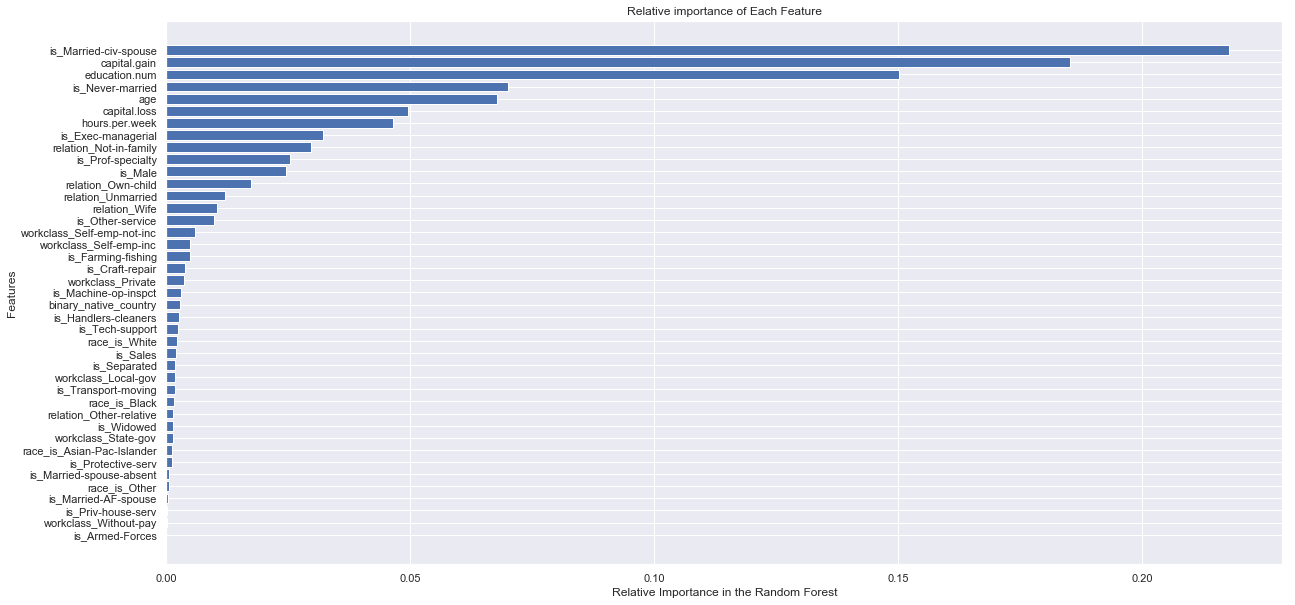

In [65]:
importance_list = rfmodel.feature_importances_
name_list = X_train.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.figure(figsize=(20,10))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

### Random forest: Grid Search and cross-validation

In [131]:
from sklearn.model_selection import cross_val_score, GridSearchCV

In [132]:
def grid_search(clf, parameters, X, y, n_jobs= -1, n_folds=4, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func,verbose =2)
    else:
        print('Doing grid search')
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, verbose =2)
    gs.fit(X, y)
    print("mean test score (weighted by split size) of CV rounds: ",gs.cv_results_['mean_test_score'] )
    print ("Best parameter set", gs.best_params_, "Corresponding mean CV score",gs.best_score_)
    best = gs.best_estimator_
    return best

In [143]:
rfmodel2 = RandomForestClassifier(min_samples_split=5,oob_score=True, n_jobs=-1,random_state=10)
parameters = {'n_estimators': [100,200,300], 'max_depth': [10,13,15,20]}
rfmodelCV = grid_search(rfmodel2, parameters,X_train,y_train)

Doing grid search
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.5min finished


mean test score (weighted by split size) of CV rounds:  [0.85489722 0.85545531 0.85568784 0.85847828 0.85847828 0.85833876
 0.85917589 0.8586178  0.85912938 0.85968747 0.85847828 0.85917589]
Best parameter set {'max_depth': 20, 'n_estimators': 100} Corresponding mean CV score 0.8596874709329365


In [144]:
rfmodelCV.fit(X_train,y_train)
show_classifier_metrics(rfmodelCV,y_train)
print('oob score = %f'% rfmodelCV.oob_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=10, verbose=0, warm_start=False)
confusion matrix of training data
[[15612   524]
 [ 1471  3895]]
confusion matrix of test data
[[6544  388]
 [ 905 1379]]
classification report of test data
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6932
           1       0.78      0.60      0.68      2284

   micro avg       0.86      0.86      0.86      9216
   macro avg       0.83      0.77      0.80      9216
weighted avg       0.85      0.86      0.85      9216

Accuracy on test data: 85.970052%
Accuracy on training data: 90.721793%
Area under the ROC curve : 0.773897
oo

## XGBoost 

In [66]:
from xgboost.sklearn import XGBClassifier

In [67]:
param = {}
param['learning_rate'] = 0.1
param['verbosity'] = 1
param['colsample_bylevel'] = 0.9
param['colsample_bytree'] = 0.9
param['subsample'] = 0.9
param['reg_lambda']= 1.5
param['max_depth'] = 5
param['n_estimators'] = 400
param['seed']=10
xgb= XGBClassifier(**param)
xgb.fit(X_train, y_train, eval_metric=['error'], eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds=30)

[0]	validation_0-error:0.150637	validation_1-error:0.152235
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.149335	validation_1-error:0.151801
[2]	validation_0-error:0.150312	validation_1-error:0.151367
[3]	validation_0-error:0.149754	validation_1-error:0.150825
[4]	validation_0-error:0.148172	validation_1-error:0.14974
[5]	validation_0-error:0.147335	validation_1-error:0.147352
[6]	validation_0-error:0.147335	validation_1-error:0.148112
[7]	validation_0-error:0.146963	validation_1-error:0.148112
[8]	validation_0-error:0.146963	validation_1-error:0.148438
[9]	validation_0-error:0.14687	validation_1-error:0.148546
[10]	validation_0-error:0.146265	validation_1-error:0.148546
[11]	validation_0-error:0.146079	validation_1-error:0.148438
[12]	validation_0-error:0.146265	validation_1-error:0.149089
[13]	validation_0-error:0.145428	validation_1-error:0.1472

[132]	validation_0-error:0.121431	validation_1-error:0.131944
[133]	validation_0-error:0.121384	validation_1-error:0.132487
[134]	validation_0-error:0.121291	validation_1-error:0.132378
[135]	validation_0-error:0.121245	validation_1-error:0.132161
[136]	validation_0-error:0.121245	validation_1-error:0.132053
[137]	validation_0-error:0.121152	validation_1-error:0.132053
[138]	validation_0-error:0.121152	validation_1-error:0.132487
[139]	validation_0-error:0.120826	validation_1-error:0.132378
[140]	validation_0-error:0.120826	validation_1-error:0.132487
[141]	validation_0-error:0.120826	validation_1-error:0.132595
[142]	validation_0-error:0.120733	validation_1-error:0.132812
[143]	validation_0-error:0.12064	validation_1-error:0.132921
[144]	validation_0-error:0.12064	validation_1-error:0.131944
[145]	validation_0-error:0.120314	validation_1-error:0.13151
[146]	validation_0-error:0.119942	validation_1-error:0.131944
[147]	validation_0-error:0.119849	validation_1-error:0.131836
[148]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=10,
       silent=True, subsample=0.9, verbosity=1)

In [68]:
show_classifier_metrics(xgb,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=10,
       silent=True, subsample=0.9, verbosity=1)
confusion matrix of training data
[[15283   853]
 [ 1627  3739]]
confusion matrix of test data
[[6534  398]
 [ 796 1488]]
classification report of test data
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6932
           1       0.79      0.65      0.71      2284

   micro avg       0.87      0.87      0.87      9216
   macro avg       0.84      0.80      0.81      9216
weighted avg       0.87      0.87      0.87      9216

Accuracy on test data: 87.044271%
Accuracy on training data: 88.466189%
Area under the ROC curve : 0.797037


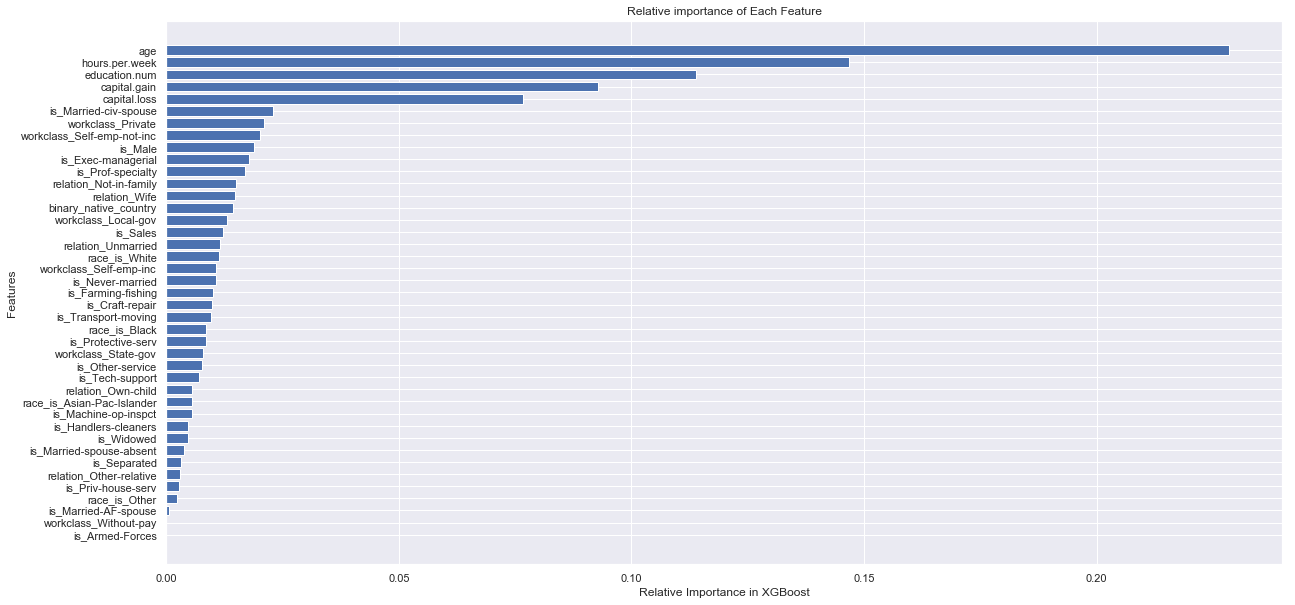

In [148]:
importance_list = xgb.feature_importances_
name_list = X_train.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.figure(figsize=(20,10))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in XGBoost')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

### Grid search with cross validation: XGBoost model

In [145]:
xgbmodel2 = XGBClassifier(seed=42)
param = {
'learning_rate': [0.1],
#'verbosity': [1],
'colsample_bylevel': [0.9],
'colsample_bytree': [0.9],
'subsample' : [0.9],
'n_estimators': [300],
'reg_lambda': [1.5,2],
'max_depth': [3,5,7],
 'seed': [10]   
}
xgbCV = grid_search(xgbmodel2, param,X_train,y_train)

Doing grid search
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.6min finished


mean test score (weighted by split size) of CV rounds:  [0.86866338 0.86833783 0.86838434 0.86889592 0.8668961  0.86638452]
Best parameter set {'colsample_bylevel': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'reg_lambda': 2, 'seed': 10, 'subsample': 0.9} Corresponding mean CV score 0.8688959166589154


In [146]:
xgbCV.fit(X_train, y_train, eval_metric=['error'], eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds=30)

[0]	validation_0-error:0.150637	validation_1-error:0.152235
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.149335	validation_1-error:0.151801
[2]	validation_0-error:0.150172	validation_1-error:0.151476
[3]	validation_0-error:0.149614	validation_1-error:0.151042
[4]	validation_0-error:0.148079	validation_1-error:0.149631
[5]	validation_0-error:0.147382	validation_1-error:0.148003
[6]	validation_0-error:0.147428	validation_1-error:0.148003
[7]	validation_0-error:0.146777	validation_1-error:0.147786
[8]	validation_0-error:0.146684	validation_1-error:0.148655
[9]	validation_0-error:0.146684	validation_1-error:0.148546
[10]	validation_0-error:0.146033	validation_1-error:0.148655
[11]	validation_0-error:0.145986	validation_1-error:0.148872
[12]	validation_0-error:0.146312	validation_1-error:0.148763
[13]	validation_0-error:0.143522	validation_1-error:0.14

[132]	validation_0-error:0.122221	validation_1-error:0.132487
[133]	validation_0-error:0.122221	validation_1-error:0.132378
[134]	validation_0-error:0.122128	validation_1-error:0.132378
[135]	validation_0-error:0.122035	validation_1-error:0.132704
[136]	validation_0-error:0.121942	validation_1-error:0.132595
[137]	validation_0-error:0.121849	validation_1-error:0.132378
[138]	validation_0-error:0.12157	validation_1-error:0.131836
[139]	validation_0-error:0.12157	validation_1-error:0.131836
[140]	validation_0-error:0.121524	validation_1-error:0.131836
[141]	validation_0-error:0.121338	validation_1-error:0.132161
[142]	validation_0-error:0.121524	validation_1-error:0.132053
[143]	validation_0-error:0.121524	validation_1-error:0.132053
[144]	validation_0-error:0.121617	validation_1-error:0.131727
[145]	validation_0-error:0.121291	validation_1-error:0.131836
[146]	validation_0-error:0.121384	validation_1-error:0.131293
[147]	validation_0-error:0.121198	validation_1-error:0.13151
[148]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=10, silent=True,
       subsample=0.9)

In [147]:
show_classifier_metrics(xgbCV,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=10, silent=True,
       subsample=0.9)
confusion matrix of training data
[[15272   864]
 [ 1666  3700]]
confusion matrix of test data
[[6533  399]
 [ 794 1490]]
classification report of test data
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6932
           1       0.79      0.65      0.71      2284

   micro avg       0.87      0.87      0.87      9216
   macro avg       0.84      0.80      0.82      9216
weighted avg       0.87      0.87      0.87      9216

Accuracy on test data: 87.055122%
Accuracy on training data: 88.233653%
Area under the ROC curve : 0.797403


In [167]:
#X_test.iloc[np.where(y_test != xgbCV.predict(X_test))]

## Logistic regression

In [99]:
from sklearn.linear_model import LogisticRegression

In [100]:
logreg = LogisticRegression(C=0.8,random_state=42,max_iter=200)
logreg.fit(X_train, y_train)

/Users/debashis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [101]:
show_classifier_metrics(logreg)

LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
confusion matrix of training data
[[14956  1180]
 [ 2074  3292]]
confusion matrix of test data
[[6418  514]
 [ 918 1366]]
classification report of test data
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6932
           1       0.73      0.60      0.66      2284

   micro avg       0.84      0.84      0.84      9216
   macro avg       0.80      0.76      0.78      9216
weighted avg       0.84      0.84      0.84      9216

Accuracy on test data: 84.461806%
Accuracy on training data: 84.866524%
Area under the ROC curve : 0.761962


## Naive Bayes

In [102]:
from sklearn.naive_bayes import GaussianNB

In [103]:
NBmodel = GaussianNB()

In [104]:
NBmodel.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [105]:
NBmodel.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [106]:
show_classifier_metrics(NBmodel,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)
confusion matrix of training data
[[13724  2412]
 [ 1390  3976]]
confusion matrix of test data
[[5919 1013]
 [ 631 1653]]
classification report of test data
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      6932
           1       0.62      0.72      0.67      2284

   micro avg       0.82      0.82      0.82      9216
   macro avg       0.76      0.79      0.77      9216
weighted avg       0.83      0.82      0.83      9216

Accuracy on test data: 82.161458%
Accuracy on training data: 82.317924%
Area under the ROC curve : 0.788798


### Stacked model

In [149]:
def create_stacked_dataset(clfs,modelnames, X_train=X_train,X_test=X_test):
    X_train_stack, X_test_stack = X_train, X_test
    for clf,modelname in zip(clfs,modelnames):
        temptrain = pd.DataFrame(clf.predict(X_train),index = X_train.index,columns=[modelname+'_prediction'])
        temptest  = pd.DataFrame(clf.predict(X_test),index = X_test.index,columns=[modelname+'_prediction'])
        X_train_stack = pd.concat([X_train_stack, temptrain], axis=1)
        X_test_stack = pd.concat([X_test_stack, temptest], axis=1)
    return (X_train_stack,X_test_stack)

In [150]:
X_train_stack,X_test_stack = create_stacked_dataset([NBmodel,rfmodel,logreg,xgb],modelnames=['NBmodel','rfmodel','logreg','xgb'])

In [151]:
X_train_stack.head(2)

,age,education.num,capital.gain,capital.loss,hours.per.week,binary_native_country,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,is_Priv-house-serv,is_Prof-specialty,is_Protective-serv,is_Sales,is_Tech-support,is_Transport-moving,NBmodel_prediction,rfmodel_prediction,logreg_prediction,xgb_prediction
31369,36,10,0,0,60,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
31013,20,6,0,0,40,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [152]:
param = {}
param['learning_rate'] = 0.1
param['verbosity'] = 1
param['colsample_bylevel'] = 0.9
param['colsample_bytree'] = 0.9
param['subsample'] = 0.9
param['reg_lambda']= 1.5
param['max_depth'] = 5#10
param['n_estimators'] = 400
param['seed']=10
xgbstack= XGBClassifier(**param)
xgbstack.fit(X_train_stack, y_train, eval_metric=['error'], eval_set=[(X_train_stack, y_train),(X_test_stack, y_test)],early_stopping_rounds=30)


[0]	validation_0-error:0.115106	validation_1-error:0.129774
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.115431	validation_1-error:0.129883
[2]	validation_0-error:0.115199	validation_1-error:0.129883
[3]	validation_0-error:0.115338	validation_1-error:0.129557
[4]	validation_0-error:0.115338	validation_1-error:0.129557
[5]	validation_0-error:0.115338	validation_1-error:0.129557
[6]	validation_0-error:0.115338	validation_1-error:0.129557
[7]	validation_0-error:0.115338	validation_1-error:0.129557
[8]	validation_0-error:0.115338	validation_1-error:0.129557
[9]	validation_0-error:0.115338	validation_1-error:0.129557
[10]	validation_0-error:0.115338	validation_1-error:0.129557
[11]	validation_0-error:0.115338	validation_1-error:0.129557
[12]	validation_0-error:0.115338	validation_1-error:0.129557
[13]	validation_0-error:0.115338	validation_1-error:0.12

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=10,
       silent=True, subsample=0.9, verbosity=1)

In [153]:
print(metrics.classification_report(y_test, xgbstack.predict(X_test_stack)))
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, xgbstack.predict(X_test_stack))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train, xgbstack.predict(X_train_stack))*100))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6932
           1       0.79      0.65      0.71      2284

   micro avg       0.87      0.87      0.87      9216
   macro avg       0.84      0.80      0.81      9216
weighted avg       0.87      0.87      0.87      9216

Accuracy on test data: 87.044271%
Accuracy on training data: 88.466189%


### Stacked model Grid Search

In [154]:
xgbstackCV = XGBClassifier(seed=10)
param_grid = {}
param_grid['learning_rate'] = [0.1]
param_grid['colsample_bylevel'] = [0.9]
param_grid['colsample_bytree'] = [0.9]
param_grid['subsample'] = [0.9]
param_grid['n_estimators'] = [300]
param_grid['reg_lambda']= [1.5]
param_grid['seed'] =[10]
param_grid['max_depth'] = [3,5,8,10]
xgbstackCV_grid = grid_search(xgbstackCV, param_grid,X_train_stack,y_train)

Doing grid search
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.6min finished


mean test score (weighted by split size) of CV rounds:  [0.88415031 0.88075528 0.87201191 0.86722165]
Best parameter set {'colsample_bylevel': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 1.5, 'seed': 10, 'subsample': 0.9} Corresponding mean CV score 0.884150311598921


In [155]:
xgbstackCV_grid.fit(X_train_stack, y_train, eval_metric=['error'], eval_set=[(X_train_stack, y_train),(X_test_stack, y_test)],early_stopping_rounds=30)

[0]	validation_0-error:0.115338	validation_1-error:0.129557
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.115338	validation_1-error:0.129557
[2]	validation_0-error:0.115338	validation_1-error:0.129557
[3]	validation_0-error:0.115338	validation_1-error:0.129557
[4]	validation_0-error:0.115338	validation_1-error:0.129557
[5]	validation_0-error:0.115338	validation_1-error:0.129557
[6]	validation_0-error:0.115338	validation_1-error:0.129557
[7]	validation_0-error:0.115338	validation_1-error:0.129557
[8]	validation_0-error:0.115338	validation_1-error:0.129557
[9]	validation_0-error:0.115338	validation_1-error:0.129557
[10]	validation_0-error:0.115338	validation_1-error:0.129557
[11]	validation_0-error:0.115338	validation_1-error:0.129557
[12]	validation_0-error:0.115338	validation_1-error:0.129557
[13]	validation_0-error:0.115338	validation_1-error:0.12

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=10,
       silent=True, subsample=0.9)

In [156]:
print(metrics.classification_report(y_test, xgbstack.predict(X_test_stack)))
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, xgbstack.predict(X_test_stack))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train, xgbstack.predict(X_train_stack))*100))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6932
           1       0.79      0.65      0.71      2284

   micro avg       0.87      0.87      0.87      9216
   macro avg       0.84      0.80      0.81      9216
weighted avg       0.87      0.87      0.87      9216

Accuracy on test data: 87.044271%
Accuracy on training data: 88.466189%


In [113]:
from catboost import CatBoostClassifier

In [114]:
catb = CatBoostClassifier(learning_rate=0.1,iterations=400,verbose=1,random_seed=10,eval_metric='Accuracy',rsm=0.9)

In [115]:
catb.fit(X_train,y_train,eval_set=[(X_train,y_train), (X_test,y_test)],early_stopping_rounds=30)

0:	learn: 0.8388057	test: 0.8388057	test1: 0.8360460	best: 0.8360460 (0)	total: 107ms	remaining: 42.5s
1:	learn: 0.8393638	test: 0.8393638	test1: 0.8370226	best: 0.8370226 (1)	total: 151ms	remaining: 30s
2:	learn: 0.8422472	test: 0.8422472	test1: 0.8385417	best: 0.8385417 (2)	total: 196ms	remaining: 26s
3:	learn: 0.8419217	test: 0.8419217	test1: 0.8394097	best: 0.8394097 (3)	total: 239ms	remaining: 23.7s
4:	learn: 0.8462004	test: 0.8462004	test1: 0.8430990	best: 0.8430990 (4)	total: 284ms	remaining: 22.5s
5:	learn: 0.8461073	test: 0.8461073	test1: 0.8434245	best: 0.8434245 (5)	total: 342ms	remaining: 22.4s
6:	learn: 0.8470840	test: 0.8470840	test1: 0.8440755	best: 0.8440755 (6)	total: 386ms	remaining: 21.7s
7:	learn: 0.8469445	test: 0.8469445	test1: 0.8433160	best: 0.8440755 (6)	total: 432ms	remaining: 21.2s
8:	learn: 0.8481072	test: 0.8481072	test1: 0.8453776	best: 0.8453776 (8)	total: 497ms	remaining: 21.6s
9:	learn: 0.8476886	test: 0.8476886	test1: 0.8457031	best: 0.8457031 (9)	tota

79:	learn: 0.8667101	test: 0.8667101	test1: 0.8619792	best: 0.8620877 (74)	total: 6.18s	remaining: 24.7s
80:	learn: 0.8666636	test: 0.8666636	test1: 0.8623047	best: 0.8623047 (80)	total: 6.28s	remaining: 24.7s
81:	learn: 0.8667566	test: 0.8667566	test1: 0.8623047	best: 0.8623047 (80)	total: 6.34s	remaining: 24.6s
82:	learn: 0.8668031	test: 0.8668031	test1: 0.8619792	best: 0.8623047 (80)	total: 6.43s	remaining: 24.6s
83:	learn: 0.8670356	test: 0.8670356	test1: 0.8618707	best: 0.8623047 (80)	total: 6.48s	remaining: 24.4s
84:	learn: 0.8669891	test: 0.8669891	test1: 0.8620877	best: 0.8623047 (80)	total: 6.53s	remaining: 24.2s
85:	learn: 0.8668961	test: 0.8668961	test1: 0.8623047	best: 0.8623047 (80)	total: 6.57s	remaining: 24s
86:	learn: 0.8670356	test: 0.8670356	test1: 0.8620877	best: 0.8623047 (80)	total: 6.62s	remaining: 23.8s
87:	learn: 0.8669891	test: 0.8669891	test1: 0.8619792	best: 0.8623047 (80)	total: 6.7s	remaining: 23.7s
88:	learn: 0.8671751	test: 0.8671751	test1: 0.8617622	best

158:	learn: 0.8735932	test: 0.8735932	test1: 0.8672960	best: 0.8672960 (157)	total: 10.7s	remaining: 16.3s
159:	learn: 0.8735932	test: 0.8735932	test1: 0.8679470	best: 0.8679470 (159)	total: 10.8s	remaining: 16.2s
160:	learn: 0.8735001	test: 0.8735001	test1: 0.8675130	best: 0.8679470 (159)	total: 10.8s	remaining: 16.1s
161:	learn: 0.8734536	test: 0.8734536	test1: 0.8672960	best: 0.8679470 (159)	total: 10.9s	remaining: 16s
162:	learn: 0.8735001	test: 0.8735001	test1: 0.8674045	best: 0.8679470 (159)	total: 10.9s	remaining: 15.9s
163:	learn: 0.8735466	test: 0.8735466	test1: 0.8674045	best: 0.8679470 (159)	total: 11s	remaining: 15.8s
164:	learn: 0.8735466	test: 0.8735466	test1: 0.8671875	best: 0.8679470 (159)	total: 11s	remaining: 15.7s
165:	learn: 0.8734071	test: 0.8734071	test1: 0.8675130	best: 0.8679470 (159)	total: 11.1s	remaining: 15.6s
166:	learn: 0.8734536	test: 0.8734536	test1: 0.8678385	best: 0.8679470 (159)	total: 11.1s	remaining: 15.5s
167:	learn: 0.8735001	test: 0.8735001	test1

237:	learn: 0.8749884	test: 0.8749884	test1: 0.8694661	best: 0.8695747 (232)	total: 15.1s	remaining: 10.3s
238:	learn: 0.8749884	test: 0.8749884	test1: 0.8693576	best: 0.8695747 (232)	total: 15.2s	remaining: 10.2s
239:	learn: 0.8748489	test: 0.8748489	test1: 0.8696832	best: 0.8696832 (239)	total: 15.2s	remaining: 10.2s
240:	learn: 0.8749419	test: 0.8749419	test1: 0.8700087	best: 0.8700087 (240)	total: 15.3s	remaining: 10.1s
241:	learn: 0.8749419	test: 0.8749419	test1: 0.8697917	best: 0.8700087 (240)	total: 15.4s	remaining: 10s
242:	learn: 0.8748489	test: 0.8748489	test1: 0.8696832	best: 0.8700087 (240)	total: 15.5s	remaining: 9.99s
243:	learn: 0.8748023	test: 0.8748023	test1: 0.8696832	best: 0.8700087 (240)	total: 15.5s	remaining: 9.91s
244:	learn: 0.8747558	test: 0.8747558	test1: 0.8696832	best: 0.8700087 (240)	total: 15.5s	remaining: 9.84s
245:	learn: 0.8748489	test: 0.8748489	test1: 0.8696832	best: 0.8700087 (240)	total: 15.6s	remaining: 9.76s
246:	learn: 0.8748023	test: 0.8748023	t

In [116]:
show_classifier_metrics(catb)

confusion matrix of training data
[[15253   883]
 [ 1809  3557]]
confusion matrix of test data
[[6575  357]
 [ 829 1455]]
classification report of test data
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6932
           1       0.80      0.64      0.71      2284

   micro avg       0.87      0.87      0.87      9216
   macro avg       0.85      0.79      0.81      9216
weighted avg       0.87      0.87      0.87      9216

Accuracy on test data: 87.131076%
Accuracy on training data: 87.480234%
Area under the ROC curve : 0.792770


In [117]:
from imblearn.over_sampling import RandomOverSampler

In [118]:
np.sum(y_train)/y_train.shape[0]

0.24955818063435958

In [119]:
ros = RandomOverSampler(random_state=1,sampling_strategy='auto')

In [120]:
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [121]:
catb_ros = CatBoostClassifier(learning_rate=0.1,iterations=400,verbose=1,random_seed=10,eval_metric='Accuracy')

In [122]:
catb_ros.fit(X_resampled,y_resampled,eval_set=[(X_resampled,y_resampled), (X_test,y_test)],early_stopping_rounds=30)

0:	learn: 0.7974095	test: 0.7974095	test1: 0.7483724	best: 0.7483724 (0)	total: 93.9ms	remaining: 37.5s
1:	learn: 0.7946517	test: 0.7946517	test1: 0.7504340	best: 0.7504340 (1)	total: 199ms	remaining: 39.6s
2:	learn: 0.8140183	test: 0.8140183	test1: 0.7870009	best: 0.7870009 (2)	total: 307ms	remaining: 40.6s
3:	learn: 0.8133986	test: 0.8133986	test1: 0.7805990	best: 0.7870009 (2)	total: 376ms	remaining: 37.3s
4:	learn: 0.8112605	test: 0.8112605	test1: 0.7815755	best: 0.7870009 (2)	total: 437ms	remaining: 34.5s
5:	learn: 0.8142662	test: 0.8142662	test1: 0.7796224	best: 0.7870009 (2)	total: 498ms	remaining: 32.7s
6:	learn: 0.8150099	test: 0.8150099	test1: 0.7819010	best: 0.7870009 (2)	total: 585ms	remaining: 32.8s
7:	learn: 0.8152268	test: 0.8152268	test1: 0.7809245	best: 0.7870009 (2)	total: 781ms	remaining: 38.3s
8:	learn: 0.8162184	test: 0.8162184	test1: 0.7816840	best: 0.7870009 (2)	total: 965ms	remaining: 41.9s
9:	learn: 0.8174888	test: 0.8174888	test1: 0.7825521	best: 0.7870009 (2)

80:	learn: 0.8476698	test: 0.8476698	test1: 0.8242188	best: 0.8246528 (76)	total: 7.65s	remaining: 30.1s
81:	learn: 0.8479177	test: 0.8479177	test1: 0.8243273	best: 0.8246528 (76)	total: 7.75s	remaining: 30s
82:	learn: 0.8481346	test: 0.8481346	test1: 0.8242188	best: 0.8246528 (76)	total: 7.8s	remaining: 29.8s
83:	learn: 0.8482895	test: 0.8482895	test1: 0.8243273	best: 0.8246528 (76)	total: 7.86s	remaining: 29.6s
84:	learn: 0.8482895	test: 0.8482895	test1: 0.8244358	best: 0.8246528 (76)	total: 7.93s	remaining: 29.4s
85:	learn: 0.8483825	test: 0.8483825	test1: 0.8249783	best: 0.8249783 (85)	total: 7.99s	remaining: 29.2s
86:	learn: 0.8484135	test: 0.8484135	test1: 0.8250868	best: 0.8250868 (86)	total: 8.05s	remaining: 29s
87:	learn: 0.8485064	test: 0.8485064	test1: 0.8249783	best: 0.8250868 (86)	total: 8.12s	remaining: 28.8s
88:	learn: 0.8487853	test: 0.8487853	test1: 0.8248698	best: 0.8250868 (86)	total: 8.19s	remaining: 28.6s
89:	learn: 0.8488163	test: 0.8488163	test1: 0.8250868	best: 

158:	learn: 0.8567799	test: 0.8567799	test1: 0.8333333	best: 0.8337674 (152)	total: 14.3s	remaining: 21.7s
159:	learn: 0.8569038	test: 0.8569038	test1: 0.8332248	best: 0.8337674 (152)	total: 14.4s	remaining: 21.6s
160:	learn: 0.8570278	test: 0.8570278	test1: 0.8328993	best: 0.8337674 (152)	total: 14.6s	remaining: 21.7s
161:	learn: 0.8570897	test: 0.8570897	test1: 0.8330078	best: 0.8337674 (152)	total: 14.7s	remaining: 21.6s
162:	learn: 0.8570588	test: 0.8570588	test1: 0.8331163	best: 0.8337674 (152)	total: 14.9s	remaining: 21.6s
163:	learn: 0.8570278	test: 0.8570278	test1: 0.8331163	best: 0.8337674 (152)	total: 15s	remaining: 21.6s
164:	learn: 0.8569348	test: 0.8569348	test1: 0.8332248	best: 0.8337674 (152)	total: 15.1s	remaining: 21.5s
165:	learn: 0.8568728	test: 0.8568728	test1: 0.8334418	best: 0.8337674 (152)	total: 15.3s	remaining: 21.5s
166:	learn: 0.8570588	test: 0.8570588	test1: 0.8331163	best: 0.8337674 (152)	total: 15.4s	remaining: 21.5s
167:	learn: 0.8574616	test: 0.8574616	t

235:	learn: 0.8608701	test: 0.8608701	test1: 0.8355035	best: 0.8360460 (218)	total: 21.9s	remaining: 15.2s
236:	learn: 0.8608701	test: 0.8608701	test1: 0.8355035	best: 0.8360460 (218)	total: 21.9s	remaining: 15.1s
237:	learn: 0.8611180	test: 0.8611180	test1: 0.8358290	best: 0.8360460 (218)	total: 22s	remaining: 15s
238:	learn: 0.8610560	test: 0.8610560	test1: 0.8360460	best: 0.8360460 (218)	total: 22.1s	remaining: 14.9s
239:	learn: 0.8613039	test: 0.8613039	test1: 0.8358290	best: 0.8360460 (218)	total: 22.2s	remaining: 14.8s
240:	learn: 0.8619546	test: 0.8619546	test1: 0.8357205	best: 0.8360460 (218)	total: 22.3s	remaining: 14.7s
241:	learn: 0.8619546	test: 0.8619546	test1: 0.8357205	best: 0.8360460 (218)	total: 22.3s	remaining: 14.6s
242:	learn: 0.8619856	test: 0.8619856	test1: 0.8357205	best: 0.8360460 (218)	total: 22.4s	remaining: 14.5s
243:	learn: 0.8620786	test: 0.8620786	test1: 0.8357205	best: 0.8360460 (218)	total: 22.5s	remaining: 14.4s
244:	learn: 0.8618927	test: 0.8618927	tes

In [123]:
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, catb_ros.predict(X_test))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_resampled, catb_ros.predict(X_resampled))*100))
print('Area under the ROC curve : %f' % (metrics.roc_auc_score(y_test, catb_ros.predict(X_test))))

Accuracy on test data: 83.604601%
Accuracy on training data: 86.021939%
Area under the ROC curve : 0.845509


### SMOTE

In [124]:
from imblearn.over_sampling import SMOTE

In [125]:
smt = SMOTE(random_state=10,sampling_strategy=0.7)
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)

In [126]:
y_train.value_counts()

0    16136
1     5366
Name: income, dtype: int64

In [127]:
np.bincount(y_train_smt)

array([16136, 11295])

In [128]:
catb_smote = CatBoostClassifier(learning_rate=0.1,iterations=400,verbose=1,random_seed=10,eval_metric='Accuracy')

In [129]:
catb_smote.fit(X_train_smt,y_train_smt,eval_set=[(X_train_smt,y_train_smt), (X_test,y_test)],early_stopping_rounds=30)

0:	learn: 0.7904561	test: 0.7904561	test1: 0.7697483	best: 0.7697483 (0)	total: 66ms	remaining: 26.3s
1:	learn: 0.7981845	test: 0.7981845	test1: 0.8231337	best: 0.8231337 (1)	total: 128ms	remaining: 25.4s
2:	learn: 0.8094127	test: 0.8094127	test1: 0.8052300	best: 0.8231337 (1)	total: 197ms	remaining: 26.1s
3:	learn: 0.8190733	test: 0.8190733	test1: 0.8143446	best: 0.8231337 (1)	total: 324ms	remaining: 32.1s
4:	learn: 0.8164850	test: 0.8164850	test1: 0.8090278	best: 0.8231337 (1)	total: 411ms	remaining: 32.5s
5:	learn: 0.8187817	test: 0.8187817	test1: 0.8189019	best: 0.8231337 (1)	total: 471ms	remaining: 30.9s
6:	learn: 0.8191462	test: 0.8191462	test1: 0.8117405	best: 0.8231337 (1)	total: 538ms	remaining: 30.2s
7:	learn: 0.8201670	test: 0.8201670	test1: 0.8196615	best: 0.8231337 (1)	total: 649ms	remaining: 31.8s
8:	learn: 0.8217345	test: 0.8217345	test1: 0.8200955	best: 0.8231337 (1)	total: 823ms	remaining: 35.8s
9:	learn: 0.8231927	test: 0.8231927	test1: 0.8190104	best: 0.8231337 (1)	t

81:	learn: 0.8668295	test: 0.8668295	test1: 0.8515625	best: 0.8519965 (79)	total: 7.1s	remaining: 27.5s
82:	learn: 0.8676315	test: 0.8676315	test1: 0.8498264	best: 0.8519965 (79)	total: 7.16s	remaining: 27.3s
83:	learn: 0.8680690	test: 0.8680690	test1: 0.8492839	best: 0.8519965 (79)	total: 7.21s	remaining: 27.1s
84:	learn: 0.8675951	test: 0.8675951	test1: 0.8515625	best: 0.8519965 (79)	total: 7.27s	remaining: 26.9s
85:	learn: 0.8676680	test: 0.8676680	test1: 0.8511285	best: 0.8519965 (79)	total: 7.33s	remaining: 26.8s
86:	learn: 0.8677773	test: 0.8677773	test1: 0.8506944	best: 0.8519965 (79)	total: 7.39s	remaining: 26.6s
87:	learn: 0.8676680	test: 0.8676680	test1: 0.8506944	best: 0.8519965 (79)	total: 7.47s	remaining: 26.5s
88:	learn: 0.8675951	test: 0.8675951	test1: 0.8509115	best: 0.8519965 (79)	total: 7.57s	remaining: 26.4s
89:	learn: 0.8677409	test: 0.8677409	test1: 0.8510200	best: 0.8519965 (79)	total: 7.65s	remaining: 26.4s
90:	learn: 0.8677044	test: 0.8677044	test1: 0.8512370	be

In [130]:
print(metrics.classification_report(y_test, catb_smote.predict(X_test)))
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, catb_smote.predict(X_test))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train_smt, catb_smote.predict(X_train_smt))*100))
print('Area under the ROC curve : %f' % (metrics.roc_auc_score(y_test, catb_ros.predict(X_test))))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      6932
           1       0.68      0.75      0.72      2284

   micro avg       0.85      0.85      0.85      9216
   macro avg       0.80      0.82      0.81      9216
weighted avg       0.86      0.85      0.85      9216

Accuracy on test data: 85.199653%
Accuracy on training data: 86.682950%
Area under the ROC curve : 0.845509
